# Sorani Kurdish data using Seaborn

Enabling _mplcairo_, with _raqm_, as the backend for _matplotlib_ will allow us to reuse the [Kurdish matplotlib example](https://github.com/enabling-languages/python-i18n/blob/main/notebooks/matplotlib_mplcairo.ipynb) with _Seaborn_.

Seaborn, which inherits _matplotlib's_ limitations with bidirectonal text and complex script rendering, also benefits from enabling _mplcario_ as the _matplotlib_ backend.

## Setup

In [16]:
import pandas as pd
import locale, platform
import mplcairo
import matplotlib as mpl
if platform.system() == "Darwin":
    mpl.use("module://mplcairo.macosx")
else:
   mpl.use("module://mplcairo.qt")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import unicodedata as ud, regex as re

## Helper functions

Open datasets often use the narrow set of Anglo-specific conventions that allows Python to recorgnise a number as either an integer or a floating point number. When scraping data from PDF files or web sites, it is possble to encoundert other numeral systems. Thesenumeral systems would not be recognised as straings to Python.

__convert_digits__ will convert a native number format into either an integer or floating point number. This can be applied as a post-processing step, or it can be applied as a converter when reading the data.

In [17]:
def convert_digits(s, sep = (",", ".")):
    nd = re.compile(r'^-?\p{Nd}[,.\u066B\u066C\u0020\u2009\p{Nd}]*$')
    tsep, dsep = sep
    if nd.match(s):
        s = s.replace(tsep, "")
        s = ''.join([str(ud.decimal(c, c)) for c in s])
        if dsep in s:
            return float(s.replace(dsep, ".")) if dsep != "." else float(s)
        return int(s)
    return s

seps = ("\u066C", "\u066B")
digitsconv = lambda x: convert_digits(x.replace("-", "٠"), sep = seps)

__convert_to_sorani_ns__ converts between decimal numeral systems.

In [18]:
def convert_to_sorani_ns(n, p=None, scale=None):
    locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
    decimal_places = 2
    n = n * scale if scale else n
    format_string = '%0.' + str(decimal_places) + 'f' if type(n) == float else '%d'
    n = locale.format_string(format_string, n, grouping=True, monetary=True)
    n = n.replace(",", "ṯ").replace(".", "ḏ")
    sep = ["\u066C", "\u066B"]
    t = n.maketrans("0123456789", "٠١٢٣٤٥٦٧٨٩")
    locale.setlocale(locale.LC_ALL, "")
    return n.translate(t).replace("ṯ", sep[0] ).replace("ḏ", sep[1])

## Process data and plot data

In [19]:
import pandas as pd
conv = {
    'سووریا': digitsconv,
    'عێراق': digitsconv,
    'ئێران': digitsconv,
    'تورکیا': digitsconv,
    'جیھانی': digitsconv
}
df = pd.read_table("../data/demographics.tsv", converters=conv)
df

,---,جیھانی,تورکیا,ئێران,عێراق,سووریا
0,کرمانجی,14419000,7919000,443000,3185000,1661000
1,ئەوانەی بە تورکی دەدوێن,5732000,5732000,0,0,0
2,باشوور,3381000,0,3381000,0,0
3,سۆرانی,1576000,0,502000,567000,0
4,زازایی - دەملی,1125000,1125000,0,0,0
5,زازایی - ئەلڤێکا,184000,179000,0,0,0
6,ڕەوەند,90000,38000,20000,33000,0
7,ھەورامی,54000,0,26000,28000,0
8,شکاکی,49000,23000,26000,0,0
9,کۆی گشتی,26712000,15016000,4398000,3916000,1661000


In [20]:
col_list=["تورکیا" ,"ئێران" ,"عێراق" ,"سووریا"]

total_df = df[col_list].sum(axis=0)
print(total_df)

تورکیا    30032000
ئێران      8796000
عێراق      7729000
سووریا     3322000
dtype: int64


Using indicies and values of the `total_df` series:

## Sorani Kurdish plot

Add Sorani Kurdish label, and axes labels. X axis tick values already in Sorani Kurdish.

Use `matplotlib.ticker.FuncFormatter()`, applying `convert_to_sorani_ns()` in order to convert Western Arabic digits to Eastern Arabic digits and scale numbers to millions.

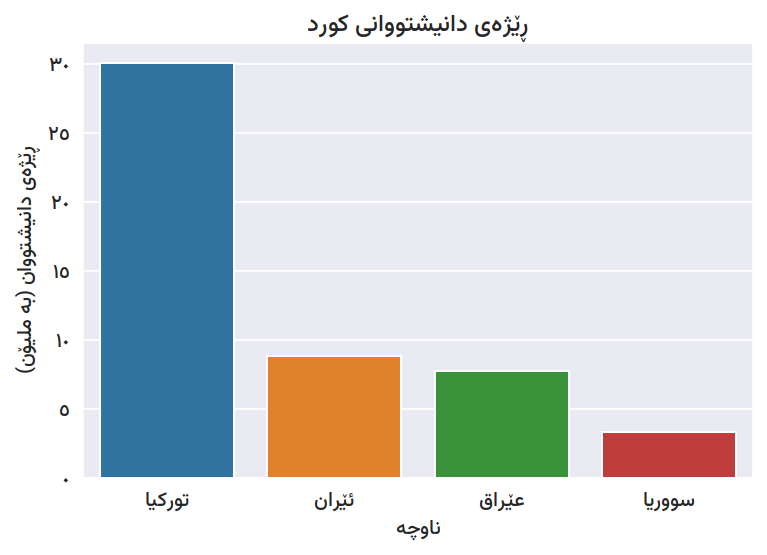

In [21]:
sns.set_style('darkgrid')
sns.set_context({"font.family": "Vazirmatn"})
bp = sns.barplot(x=total_df.index, y=total_df.values)
bp.set_title('ڕێژەی دانیشتووانی کورد')
bp.set_xlabel("ناوچە")
bp.set_ylabel("ڕێژەی دانیشتووان (بە ملیۆن)")
ns_formatter = ticker.FuncFormatter(lambda x, p: convert_to_sorani_ns(x, p, scale=0.000001))
bp.get_yaxis().set_major_formatter(ns_formatter)
#plt.show()

## Convert layout to RTL

It isn't always necessary to chnage the layout of the plot. If the plot is using a cartesian coordinate system, it is best to use the default layout. The layout used, combinined with user expectations and impact the interpretation of trends in data visualisations.

If a RTL layour is required:

1. Use `yaxis.tick_right()` and `yaxis.set_label_position("right")` to reposition y-axis to the right side of the plot
2. Use plt.gca().invert_xaxis() to invert the x-axis. This step may not be necessary. UX is an important consideration.

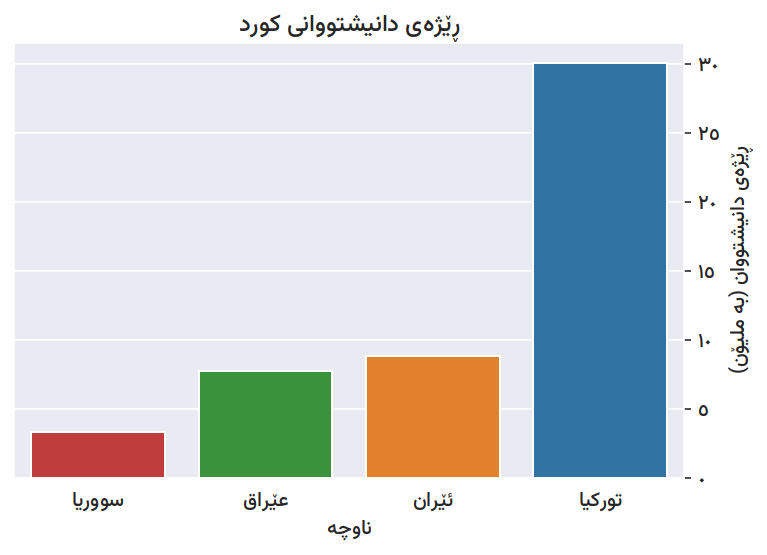

In [22]:
sns.set_style('darkgrid')
sns.set_context({"font.family": "Vazirmatn"})
bp = sns.barplot(x=total_df.index, y=total_df.values)

# move y axis and associated label to right of plot
bp.yaxis.tick_right()
bp.yaxis.set_label_position("right")
# invert x-axis
plt.gca().invert_xaxis()

bp.set_title('ڕێژەی دانیشتووانی کورد')
bp.set_xlabel("ناوچە")
bp.set_ylabel("ڕێژەی دانیشتووان (بە ملیۆن)")
ns_formatter = ticker.FuncFormatter(lambda x, p: convert_to_sorani_ns(x, p, scale=0.000001))
bp.get_yaxis().set_major_formatter(ns_formatter)
#plt.show()